In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Carpeta donde están TODOS los TXT de usu_individual
base_path = "/content/drive/MyDrive/TP_Analisis_de_datos/2trimestre_anio_archivostxt"  # <- cambiala si hace falta

# Archivo del IPC
ruta_ipc = "/content/drive/MyDrive/TP_Analisis_de_datos/sh_ipc_aperturas.xlsx"  # <- ruta correcta del xlsx


Mounted at /content/drive


In [2]:
# Detectar año y trimestre desde el nombre del archivo
def parse_year_trim(filename: str):
    m = re.search(r'[tT](\d)(\d{2})', filename)
    if m is None:
        raise ValueError(f"No se pudo extraer año/trimestre de: {filename}")
    trim = int(m.group(1))
    yy   = int(m.group(2))
    anio = 2000 + yy           # 17 -> 2017, etc.
    return anio, trim

# Leer un TXT de la EPH
def leer_archivo_eph(path):
    df = pd.read_csv(
        path,
        sep=';',
        encoding='latin1',
        low_memory=False
    )
    return df

# Elegir ponderador individual
def elegir_ponderador(columns):
    if "PONDIIO" in columns:
        return "PONDIIO"
    elif "PONDERA" in columns:
        return "PONDERA"
    elif "PONDIH" in columns:
        return "PONDIH"
    else:
        raise ValueError(
            "No se encontró columna de ponderador individual "
            "(PONDIIO / PONDERA / PONDIH)."
        )

# Calcular tasas ponderadas ocupación / desocupación / inactividad
def calcular_tasas_ponderadas(df, ponder_col):
    w = df[ponder_col]

    ocup = (df["ocupado"]     * w).sum()
    deso = (df["desocupado"]  * w).sum()
    inact = (df["inactivo"]   * w).sum()

    poblacion = w.sum()
    pea = ocup + deso

    tasa_act = pea / poblacion * 100 if poblacion > 0 else np.nan
    tasa_emp = ocup / poblacion * 100 if poblacion > 0 else np.nan
    tasa_des = deso / pea * 100       if pea > 0 else np.nan

    return pd.Series({
        "ocupados": ocup,
        "desocupados": deso,
        "inactivos": inact,
        "poblacion": poblacion,
        "pea": pea,
        "tasa_actividad": tasa_act,
        "tasa_empleo": tasa_emp,
        "tasa_desocup": tasa_des
    })

In [3]:
#Cargar todos los trimestres 2016-2025
def cargar_todos_los_trimestres(base_path):
    archivos = [
        f for f in os.listdir(base_path)
        if "usu_individual" in f.lower() and f.lower().endswith(".txt")
    ]
    archivos = sorted(archivos)   # para que quede prolijo

    dfs = []

    for f in archivos:
        path = os.path.join(base_path, f)
        anio, trim = parse_year_trim(f)
        print(f"Cargando: {f} -> Año {anio}, trimestre {trim}")

        df = leer_archivo_eph(path)

        # columnas de año y trimestre
        df["anio"] = anio
        df["trimestre"] = trim

        # Filtrar aglomerados de interés
        if "AGLOMERADO" not in df.columns:
            print("ATENCIÓN: archivo sin columna AGLOMERADO:", f)
            continue

        df = df[df["AGLOMERADO"].isin([19, 34])]  # 19: Gran Jujuy, 34: Mar del Plata

        dfs.append(df)

    if not dfs:
        raise ValueError("No se cargó ningún archivo. ¿base_path correcto?")

    eph = pd.concat(dfs, ignore_index=True)
    return eph


eph = cargar_todos_los_trimestres(base_path)
eph.head()

Cargando: Usu_Individual_T417.txt -> Año 2017, trimestre 4
Cargando: Usu_individual_T319.txt -> Año 2019, trimestre 3
Cargando: usu_Individual_T220.txt -> Año 2020, trimestre 2
Cargando: usu_individual_T120.txt -> Año 2020, trimestre 1
Cargando: usu_individual_T121.txt -> Año 2021, trimestre 1
Cargando: usu_individual_T122.txt -> Año 2022, trimestre 1
Cargando: usu_individual_T123.txt -> Año 2023, trimestre 1
Cargando: usu_individual_T124.txt -> Año 2024, trimestre 1
Cargando: usu_individual_T125.txt -> Año 2025, trimestre 1
Cargando: usu_individual_T216.txt -> Año 2016, trimestre 2
Cargando: usu_individual_T217.txt -> Año 2017, trimestre 2
Cargando: usu_individual_T218.txt -> Año 2018, trimestre 2
Cargando: usu_individual_T219.txt -> Año 2019, trimestre 2
Cargando: usu_individual_T221.txt -> Año 2021, trimestre 2
Cargando: usu_individual_T222.txt -> Año 2022, trimestre 2
Cargando: usu_individual_T223.txt -> Año 2023, trimestre 2
Cargando: usu_individual_T224.txt -> Año 2024, trimestre

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,V22_01_M,V22_02_M,V22_03_M,P_DECCF,P_RDECCF,P_GDECCF,P_PDECCF,P_IDECCF,P_ADECCF,Unnamed: 177
0,TQRMNOQQVHKMLLCDEGPDJ00491885,2017,4,1,1,1,40,N,19,222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TQRMNOQQVHKMLLCDEGPDJ00491885,2017,4,1,2,1,40,N,19,222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TQRMNOQQVHKMLLCDEGPDJ00491885,2017,4,1,3,1,40,N,19,222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TQRMNOQQVHKMLLCDEGPDJ00491885,2017,4,1,4,0,40,N,19,222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TQRMNOQQVHKMLLCDEGPDJ00491885,2017,4,1,5,0,40,N,19,222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Variables laborales (1 ocupado, 2 desocupado, 3 inactivo)
eph["ocupado"]    = (eph["ESTADO"] == 1).astype(int)
eph["desocupado"] = (eph["ESTADO"] == 2).astype(int)
eph["inactivo"]   = (eph["ESTADO"] == 3).astype(int)

# Seleccionar ponderador sobre el DF completo
ponder_col = elegir_ponderador(eph.columns)
print("Ponderador usado:", ponder_col)

# Convertir ingreso (P47T) a numérico para evitar el error de comparación
eph["P47T"] = pd.to_numeric(eph["P47T"], errors="coerce")

Ponderador usado: PONDIIO


In [5]:
#Tasas de actividad, empleo y desocupación
tasas = (
    eph
    .groupby(["anio", "trimestre", "AGLOMERADO"])
    .apply(lambda df: calcular_tasas_ponderadas(df, ponder_col))
    .reset_index()
)

tasas.head()

/tmp/ipython-input-1449379135.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: calcular_tasas_ponderadas(df, ponder_col))


,anio,trimestre,AGLOMERADO,ocupados,desocupados,inactivos,poblacion,pea,tasa_actividad,tasa_empleo,tasa_desocup
0,2016,2,19,134565.0,6324.0,135784.0,332968.0,140889.0,42.313075,40.413794,4.488640
1,2016,2,34,250719.0,32974.0,264645.0,622087.0,283693.0,45.603428,40.302884,11.623128
2,2016,3,19,135397.0,3635.0,141272.0,333692.0,139032.0,41.664769,40.575441,2.614506
3,2016,3,34,247289.0,34129.0,255973.0,623492.0,281418.0,45.135784,39.661936,12.127511
4,2016,4,19,133992.0,5183.0,141861.0,334690.0,139175.0,41.583256,40.034659,3.724088


In [6]:
#Ingreso nominal ponderado (media)
# Personas con ingreso declarado (pueden definir >0 o >=0 según acuerden)
eph_ing = eph[eph["P47T"] > 0].copy()

ingresos = (
    eph_ing
    .groupby(["anio", "trimestre", "AGLOMERADO"])
    .apply(lambda df: (df["P47T"] * df[ponder_col]).sum() / df[ponder_col].sum())
    .reset_index(name="ingreso_nominal_prom")
)

ingresos.head()

/tmp/ipython-input-3517639007.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df["P47T"] * df[ponder_col]).sum() / df[ponder_col].sum())


,anio,trimestre,AGLOMERADO,ingreso_nominal_prom
0,2016,2,19,7336.837381
1,2016,2,34,9172.104972
2,2016,3,19,9515.109639
3,2016,3,34,11984.136512
4,2016,4,19,9388.928171


In [7]:
#Ingreso real usando IPC
ruta_ipc = "/content/drive/MyDrive/TP_Analisis_de_datos/sh_ipc_aperturas.xlsx"

# Leer IPC desde el Excel
raw_ipc = pd.read_excel(
    ruta_ipc,
    sheet_name="Índices aperturas",  # nombre exacto de la hoja
    header=None,
    engine="openpyxl"
)

# Ajustar estas filas/columnas según tu archivo (como antes)
fila_fechas = raw_ipc.iloc[5, 1:]
fila_ipc    = raw_ipc.iloc[7, 1:]

ipc_mensual = pd.DataFrame({
    "fecha": pd.to_datetime(fila_fechas.values, errors="coerce"),
    "ipc":   pd.to_numeric(fila_ipc.values, errors="coerce")
}).dropna()

ipc_mensual["anio"] = ipc_mensual["fecha"].dt.year
ipc_mensual["mes"]  = ipc_mensual["fecha"].dt.month
ipc_mensual["trimestre"] = ((ipc_mensual["mes"] - 1) // 3) + 1

ipc_trim = (
    ipc_mensual
    .groupby(["anio", "trimestre"])["ipc"]
    .mean()
    .reset_index()
)

ipc_trim.head()

,anio,trimestre,ipc
0,2016,4,100.000000
1,2017,1,103.794733
2,2017,2,110.505433
3,2017,3,115.829533
4,2017,4,121.810600


In [8]:
ingresos_real = ingresos.merge(ipc_trim, on=["anio", "trimestre"], how="left")

ingresos_real["ingreso_real_prom"] = (
    ingresos_real["ingreso_nominal_prom"] / (ingresos_real["ipc"] / 100)
)

ingresos_real.head()

,anio,trimestre,AGLOMERADO,ingreso_nominal_prom,ipc,ingreso_real_prom
0,2016,2,19,7336.837381,NaN,NaN
1,2016,2,34,9172.104972,NaN,NaN
2,2016,3,19,9515.109639,NaN,NaN
3,2016,3,34,11984.136512,NaN,NaN
4,2016,4,19,9388.928171,100.0,9388.928171


In [9]:
#PANEL FINAL: INGRESO REAL + TASAS LABORALES
panel = ingresos_real.merge(
    tasas,
    on=["anio", "trimestre", "AGLOMERADO"],
    how="left"
)

panel.head()
panel.describe()

,anio,trimestre,AGLOMERADO,ingreso_nominal_prom,ipc,ingreso_real_prom,ocupados,desocupados,inactivos,poblacion,pea,tasa_actividad,tasa_empleo,tasa_desocup
count,74.000000,74.000000,74.000000,7.400000e+01,70.000000,70.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,2020.378378,2.486486,26.500000,1.307340e+05,1662.081384,9214.589376,214985.216216,19374.878378,197335.675676,496934.175676,234360.094595,46.770737,43.176673,7.693797
std,2.713249,1.113347,7.551195,2.202841e+05,2559.160275,2070.081665,68745.352902,12312.502371,59395.051268,150455.282434,78065.877169,2.862057,3.073492,3.485221
min,2016.000000,1.000000,19.000000,7.336837e+03,100.000000,5226.313612,128547.000000,3635.000000,126733.000000,332968.000000,138282.000000,38.776541,28.681992,2.614506
25%,2018.000000,2.000000,19.000000,1.658377e+04,183.438433,7333.885173,149860.500000,8786.000000,139170.000000,348329.000000,160212.250000,45.403443,42.002888,5.177182
50%,2020.000000,2.000000,26.500000,3.341007e+04,405.794900,9081.143615,178463.500000,16851.500000,193117.500000,492294.000000,214057.500000,47.033539,43.518982,7.093929
75%,2023.000000,3.000000,34.000000,9.682272e+04,1504.808958,10876.312179,283559.000000,29204.250000,252626.500000,645871.500000,313023.250000,48.684561,45.141427,9.378611
max,2025.000000,4.000000,34.000000,1.005106e+06,8691.376367,13985.997766,315940.000000,64967.000000,318212.000000,668855.000000,348209.000000,52.644716,47.766059,26.032617


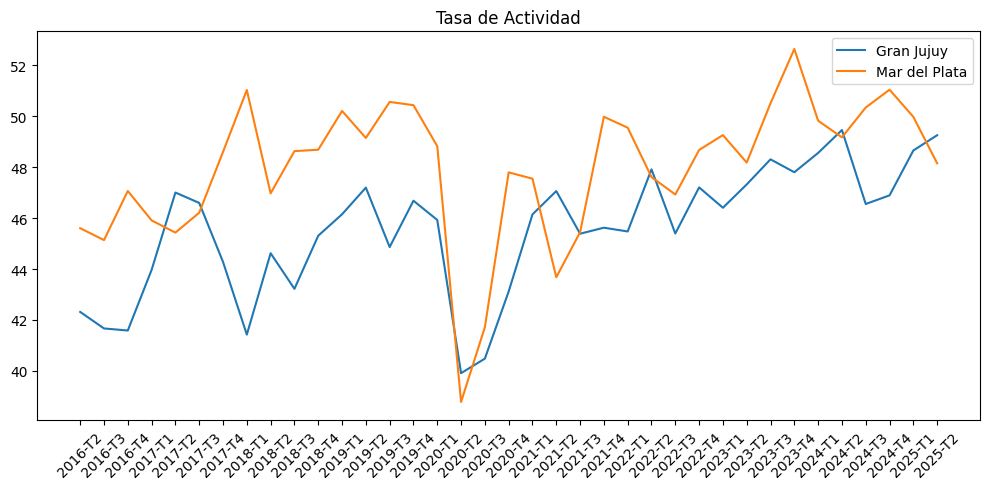

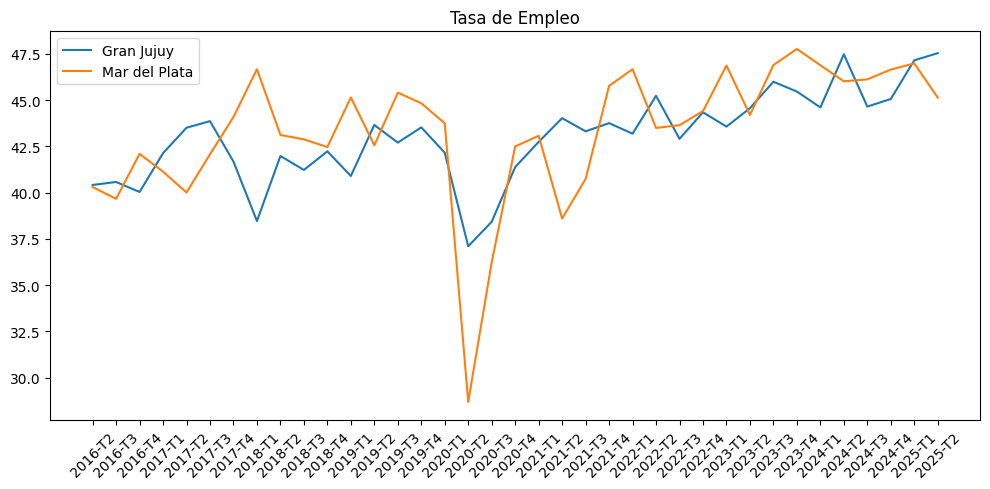

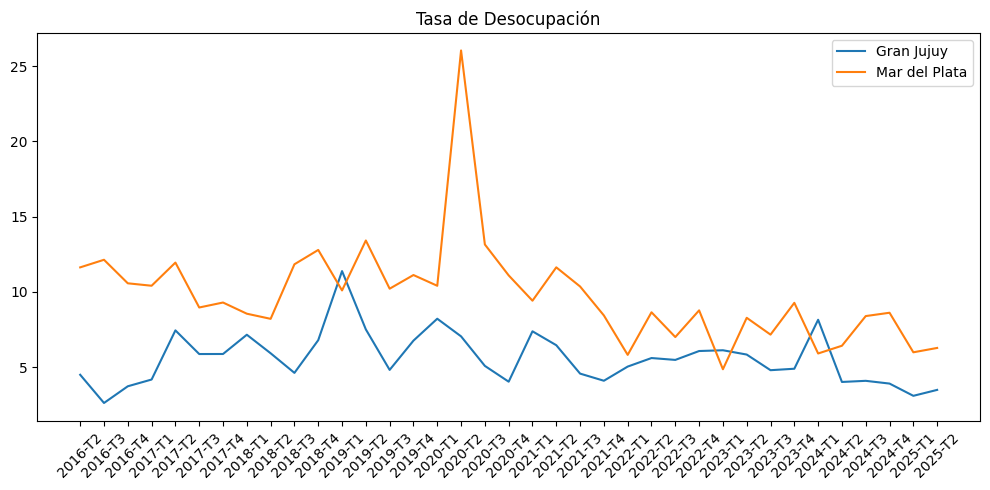

In [10]:
#GRAFICOS Tasas laborales por aglomerado (Actividad, Empleo, Desocupación)
def graficar_tasa(panel, variable, titulo):
    plt.figure(figsize=(10,5))
    for aglo, nombre in [(19, "Gran Jujuy"), (34, "Mar del Plata")]:
        df_plot = panel[panel["AGLOMERADO"] == aglo]
        df_plot = df_plot.sort_values(["anio", "trimestre"])
        plt.plot(
            df_plot["anio"].astype(str) + "-T" + df_plot["trimestre"].astype(str),
            df_plot[variable],
            label=nombre
        )

    plt.xticks(rotation=45)
    plt.title(titulo)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Gráficos
graficar_tasa(panel, "tasa_actividad", "Tasa de Actividad")
graficar_tasa(panel, "tasa_empleo", "Tasa de Empleo")
graficar_tasa(panel, "tasa_desocup", "Tasa de Desocupación")


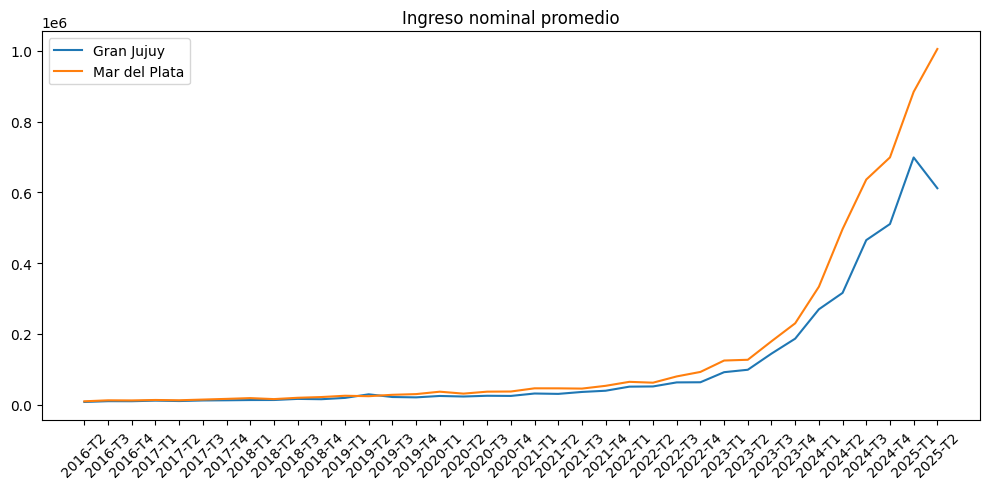

In [11]:
#GRAFICOS Ingreso nominal promedio
def graficar_ingreso(panel, variable, titulo):
    plt.figure(figsize=(10,5))
    for aglo, nombre in [(19, "Gran Jujuy"), (34, "Mar del Plata")]:
        df_plot = panel[panel["AGLOMERADO"] == aglo]
        df_plot = df_plot.sort_values(["anio", "trimestre"])
        plt.plot(
            df_plot["anio"].astype(str) + "-T" + df_plot["trimestre"].astype(str),
            df_plot[variable],
            label=nombre
        )
    plt.xticks(rotation=45)
    plt.title(titulo)
    plt.legend()
    plt.tight_layout()
    plt.show()

graficar_ingreso(panel, "ingreso_nominal_prom", "Ingreso nominal promedio")


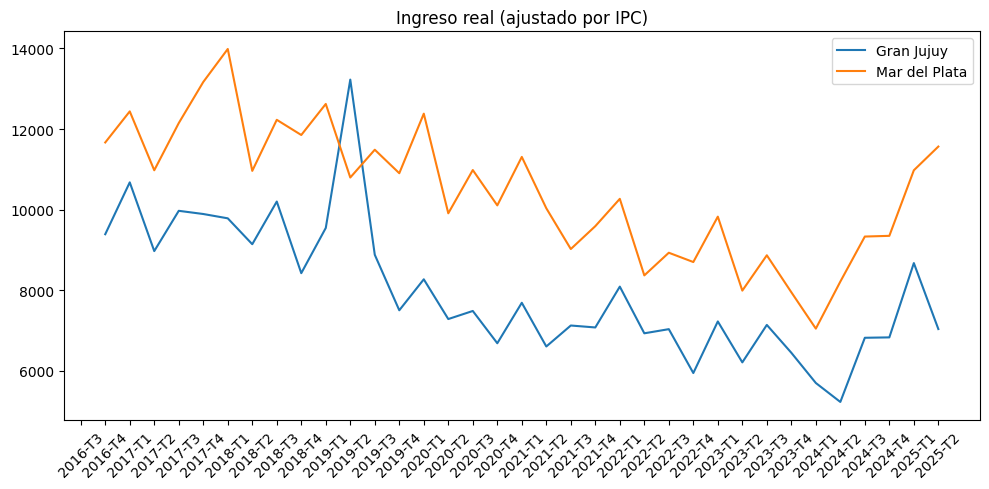

In [12]:
#GRAFICO Ingreso real promedio
graficar_ingreso(panel, "ingreso_real_prom", "Ingreso real (ajustado por IPC)")

In [13]:
#GENERAR TABLAS TIPO INFORME (RESÚMENES ANUALES)
panel_resumen = (
    panel.groupby(["anio", "AGLOMERADO"])[
        ["tasa_actividad", "tasa_empleo", "tasa_desocup",
         "ingreso_nominal_prom", "ingreso_real_prom"]
    ]
    .mean()
    .reset_index()
)

panel_resumen


,anio,AGLOMERADO,tasa_actividad,tasa_empleo,tasa_desocup,ingreso_nominal_prom,ingreso_real_prom
0,2016,19,41.853700,40.341298,3.609078,8746.958397,9388.928171
1,2016,34,45.935070,40.686226,11.438276,10940.781259,11666.102293
2,2017,19,45.461385,42.795877,5.836004,11147.422781,9876.705849
3,2017,34,46.538467,41.824871,10.147369,13786.712365,12181.806905
4,2018,19,43.643155,40.975464,6.116700,14157.310667,9386.622862
5,2018,34,48.830842,43.783472,10.339664,18493.015984,12256.647801
6,2019,19,46.223240,42.697405,7.611458,22335.525258,9787.584254
7,2019,34,50.090502,44.484572,11.205141,26390.047938,11451.714824
8,2020,19,42.357958,39.764661,6.089396,24041.391877,7430.319240
9,2020,34,44.277797,37.788771,15.166833,35121.225148,10843.804719


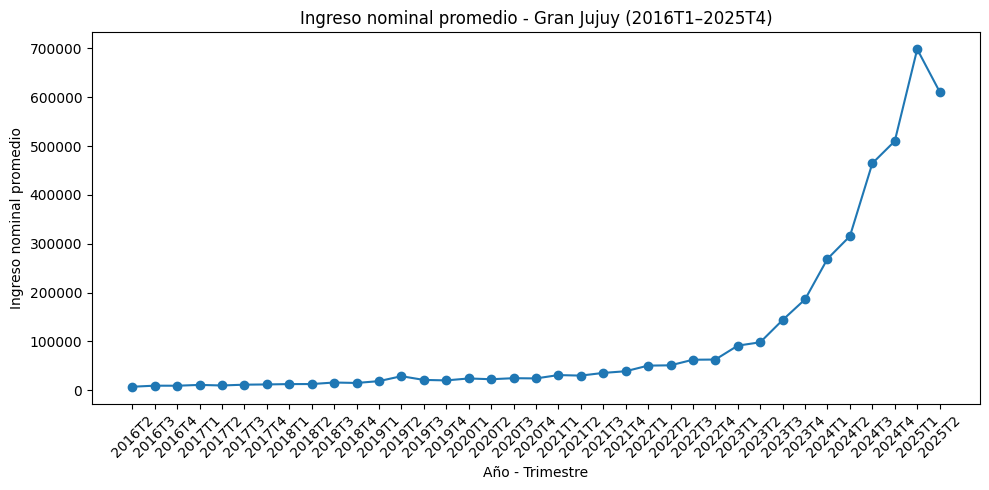

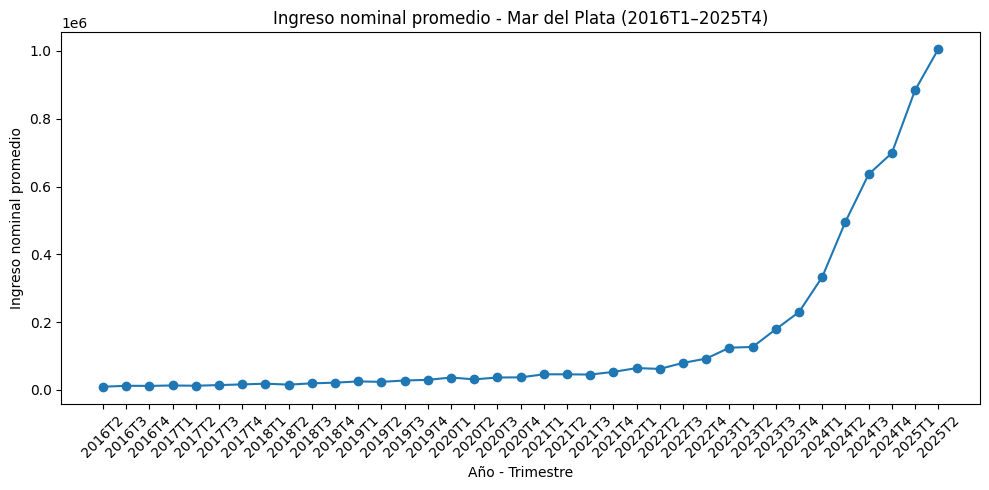

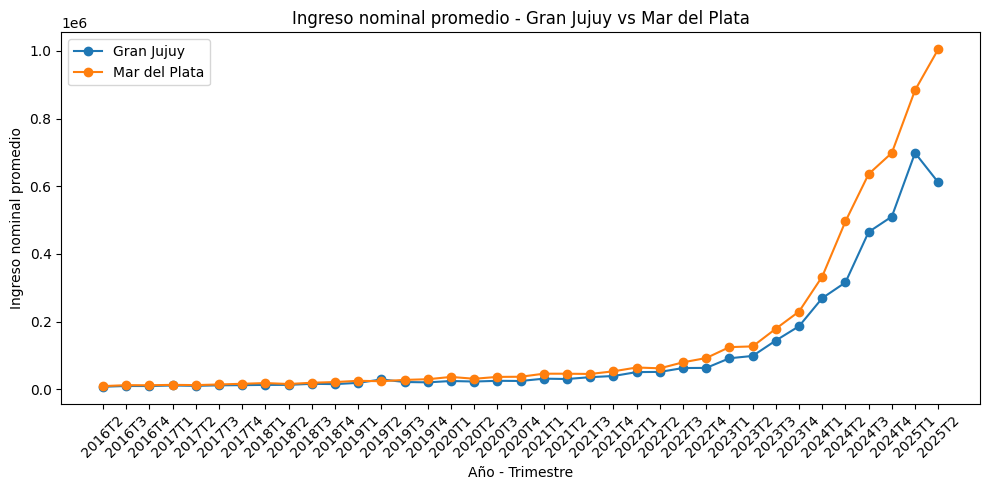

In [14]:
import matplotlib.pyplot as plt

# Ordenamos y creamos una columna periodo tipo "2016T1"
panel = panel.sort_values(["anio", "trimestre", "AGLOMERADO"]).copy()
panel["periodo"] = panel["anio"].astype(str) + "T" + panel["trimestre"].astype(str)

# Ingreso nominal promedio - Gran Jujuy (AGLOMERADO 19)
jj = panel[panel["AGLOMERADO"] == 19]

plt.figure(figsize=(10, 5))
plt.plot(jj["periodo"], jj["ingreso_nominal_prom"], marker="o")
plt.title("Ingreso nominal promedio - Gran Jujuy (2016T1–2025T4)")
plt.xlabel("Año - Trimestre")
plt.ylabel("Ingreso nominal promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Ingreso nominal promedio - Mar del Plata (AGLOMERADO 34)
mdp = panel[panel["AGLOMERADO"] == 34]

plt.figure(figsize=(10, 5))
plt.plot(mdp["periodo"], mdp["ingreso_nominal_prom"], marker="o")
plt.title("Ingreso nominal promedio - Mar del Plata (2016T1–2025T4)")
plt.xlabel("Año - Trimestre")
plt.ylabel("Ingreso nominal promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comparación de ingreso nominal promedio - ambos aglomerados
plt.figure(figsize=(10, 5))

plt.plot(jj["periodo"], jj["ingreso_nominal_prom"], marker="o", label="Gran Jujuy")
plt.plot(mdp["periodo"], mdp["ingreso_nominal_prom"], marker="o", label="Mar del Plata")

plt.title("Ingreso nominal promedio - Gran Jujuy vs Mar del Plata")
plt.xlabel("Año - Trimestre")
plt.ylabel("Ingreso nominal promedio")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# TABLA 1: Medidas de tendencia central y de posición – Gran Jujuy

tabla_jujuy = panel[panel["AGLOMERADO"] == 19]["ingreso_nominal_prom"].agg([
    "mean", "median", "min", "max",
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75)
]).to_frame(name="Gran Jujuy")

tabla_jujuy.index = ["Media", "Mediana", "Mínimo", "Máximo", "P25", "P75"]
tabla_jujuy


,Gran Jujuy
Media,109905.816347
Mediana,28917.386278
Mínimo,7336.837381
Máximo,698472.099274
P25,15066.914551
P75,91496.617023


In [16]:
# TABLA 2: Medidas de tendencia central y de posición – Mar del Plata

tabla_mdp = panel[panel["AGLOMERADO"] == 34]["ingreso_nominal_prom"].agg([
    "mean", "median", "min", "max",
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75)
]).to_frame(name="Mar del Plata")

tabla_mdp.index = ["Media", "Mediana", "Mínimo", "Máximo", "P25", "P75"]
tabla_mdp


,Mar del Plata
Media,1.515623e+05
Mediana,3.683615e+04
Mínimo,9.172105e+03
Máximo,1.005106e+06
P25,1.914853e+04
P75,1.244334e+05


In [17]:
# ==== VARIABLES PARA MULTIVARIADO ====

# Sexo
eph["sexo"] = eph["CH04"].map({1: "Varón", 2: "Mujer"})

# Edad simple
eph["edad"] = eph["CH06"]

# Grupos de edad
eph["grupo_edad"] = pd.cut(
    eph["edad"],
    bins=[14, 29, 44, 64, 120],     # 15–29, 30–44, 45–64, 65+
    labels=["15-29", "30-44", "45-64", "65 y más"]
)

# Nivel educativo (como antes)
def clasificar_educacion(nivel):
    if pd.isna(nivel):
        return np.nan
    nivel = int(nivel)
    if nivel in [1, 2, 3]:
        return "Bajo (primario o menos)"
    elif nivel in [4, 5]:
        return "Medio (secundario)"
    elif nivel in [6, 7, 8]:
        return "Alto (superior/uni)"
    else:
        return np.nan

eph["educacion"] = eph["NIVEL_ED"].apply(clasificar_educacion)

# Subconjunto con ingreso declarado (lo vamos a reutilizar varias veces)
eph_ing = eph[eph["P47T"] > 0].copy()

def calcular_tasas_ponderadas(df, ponder_col):
    w = df[ponder_col]

    ocup = (df["ocupado"]     * w).sum()
    deso = (df["desocupado"]  * w).sum()
    inact = (df["inactivo"]   * w).sum()

    poblacion = w.sum()
    pea = ocup + deso

    tasa_act = pea / poblacion * 100 if poblacion > 0 else np.nan
    tasa_emp = ocup / poblacion * 100 if poblacion > 0 else np.nan
    tasa_des = deso / pea * 100 if pea > 0 else np.nan

    return pd.Series({
        "ocupados":        ocup,
        "desocupados":     deso,
        "inactivos":       inact,
        "poblacion":       poblacion,
        "pea":             pea,
        "tasa_actividad":  tasa_act,
        "tasa_empleo":     tasa_emp,
        "tasa_desocup":    tasa_des,
    })

In [18]:
#Ingreso nominal promedio por sexo
ingreso_sexo = (
    eph_ing
    .groupby(["anio", "trimestre", "AGLOMERADO", "sexo"])[["P47T", ponder_col]]
    .apply(lambda df: (df["P47T"] * df[ponder_col]).sum() / df[ponder_col].sum())
    .reset_index(name="ingreso_nominal_prom")
)

ingreso_sexo.head()

,anio,trimestre,AGLOMERADO,sexo,ingreso_nominal_prom
0,2016,2,19,Mujer,6467.225271
1,2016,2,19,Varón,8212.043499
2,2016,2,34,Mujer,8077.116051
3,2016,2,34,Varón,10235.383637
4,2016,3,19,Mujer,8485.422970


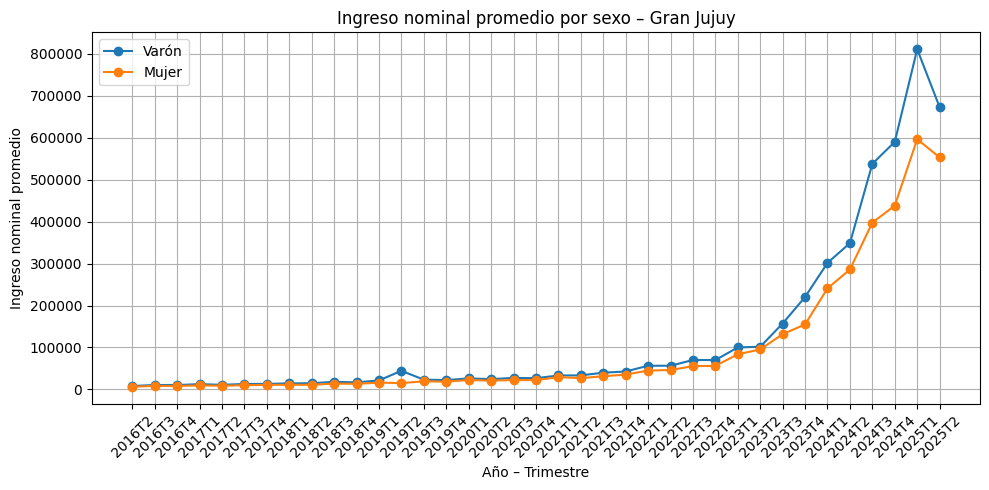

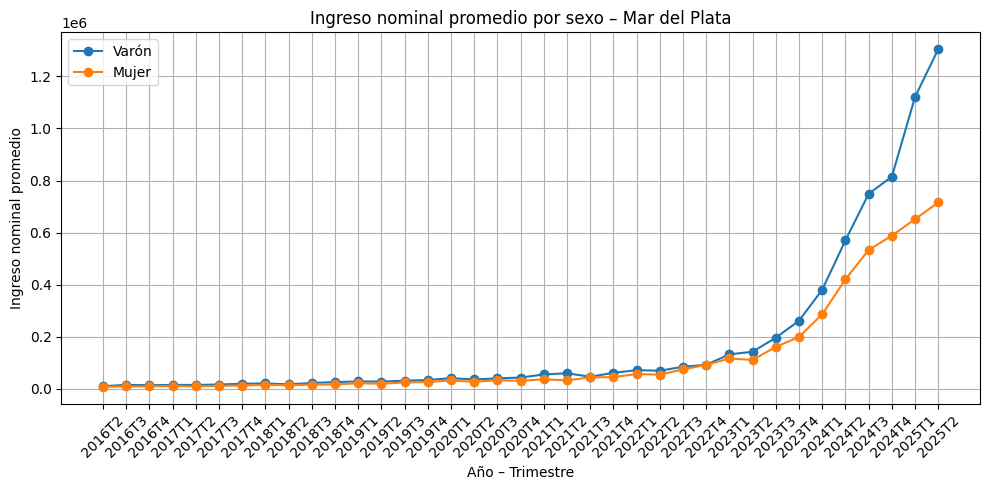

In [19]:
import matplotlib.pyplot as plt

def plot_ingreso_sexo(aglo, nombre):
    df = ingreso_sexo[ingreso_sexo["AGLOMERADO"] == aglo].copy()
    df["periodo"] = df["anio"].astype(str) + "T" + df["trimestre"].astype(str)

    plt.figure(figsize=(10, 5))
    for s in ["Varón", "Mujer"]:
        sub = df[df["sexo"] == s]
        plt.plot(sub["periodo"], sub["ingreso_nominal_prom"], marker="o", label=s)

    plt.xticks(rotation=45)
    plt.title(f"Ingreso nominal promedio por sexo – {nombre}")
    plt.xlabel("Año – Trimestre")
    plt.ylabel("Ingreso nominal promedio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Jujuy y Mar del Plata
plot_ingreso_sexo(19, "Gran Jujuy")
plot_ingreso_sexo(34, "Mar del Plata")

In [20]:
#Ingreso nominal promedio por nivel educativo
ingreso_educ = (
    eph_ing[eph_ing["educacion"].notna()]
    .groupby(["anio", "trimestre", "AGLOMERADO", "educacion"])[["P47T", ponder_col]]
    .apply(lambda df: (df["P47T"] * df[ponder_col]).sum() / df[ponder_col].sum())
    .reset_index(name="ingreso_nominal_prom")
)

ingreso_educ.head()

,anio,trimestre,AGLOMERADO,educacion,ingreso_nominal_prom
0,2016,2,19,Alto (superior/uni),10432.431683
1,2016,2,19,Bajo (primario o menos),5811.506125
2,2016,2,19,Medio (secundario),7149.835759
3,2016,2,34,Alto (superior/uni),15854.630572
4,2016,2,34,Bajo (primario o menos),6540.871801


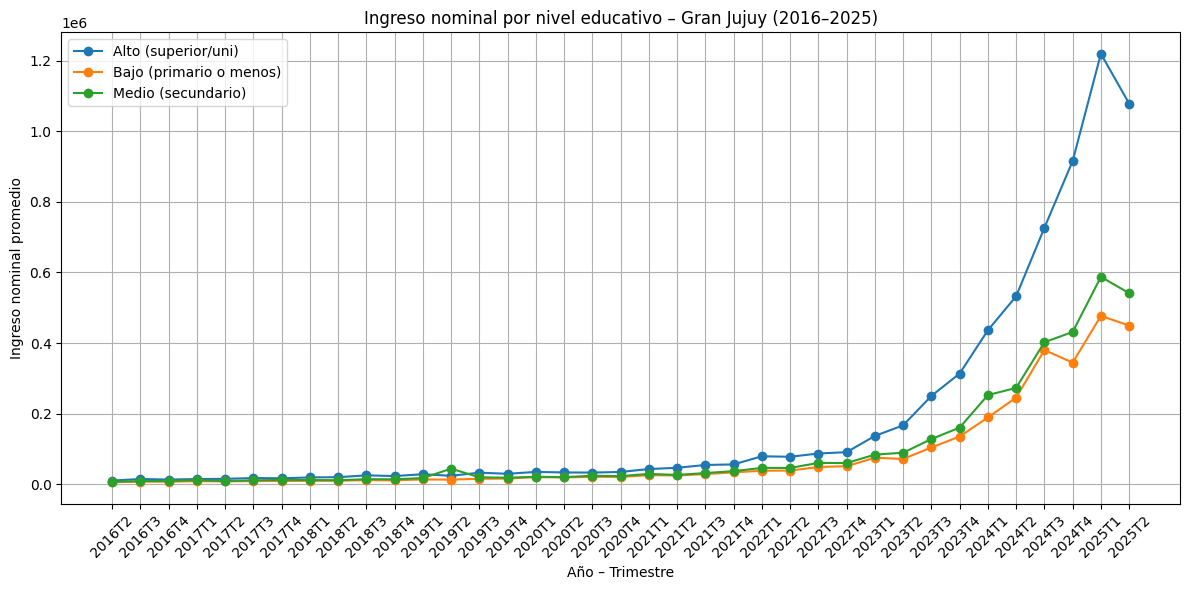

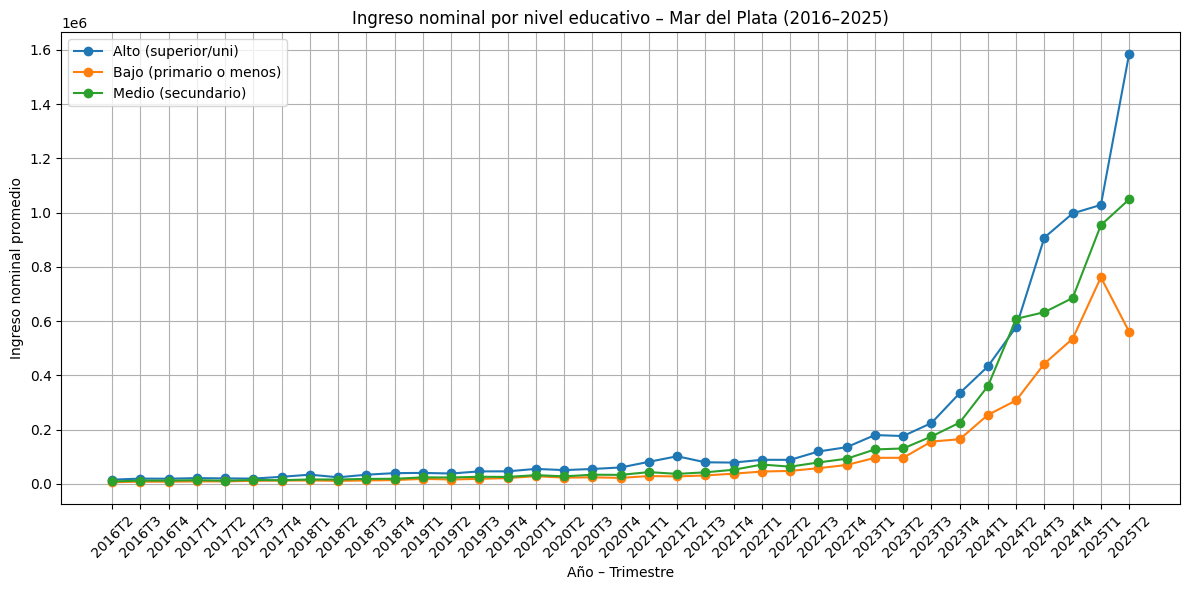

In [21]:
def plot_ingreso_educ(aglo, nombre):
    df = ingreso_educ[ingreso_educ["AGLOMERADO"] == aglo].copy()
    df["periodo"] = df["anio"].astype(str) + "T" + df["trimestre"].astype(str)

    plt.figure(figsize=(12,6))
    for niv in df["educacion"].unique():
        sub = df[df["educacion"] == niv]
        plt.plot(sub["periodo"], sub["ingreso_nominal_prom"], marker="o", label=niv)

    plt.xticks(rotation=45)
    plt.title(f"Ingreso nominal por nivel educativo – {nombre} (2016–2025)")
    plt.xlabel("Año – Trimestre")
    plt.ylabel("Ingreso nominal promedio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ingreso_educ(19, "Gran Jujuy")
plot_ingreso_educ(34, "Mar del Plata")


In [22]:
#Tasas laborales por nivel educativo
if "educacion" not in eph.columns and "NIVEL_ED" in eph.columns:
    eph["educacion"] = eph["NIVEL_ED"].astype(str)

# Tasas laborales por nivel educativo
tasas_educ = (
    eph[eph["educacion"].notna()]
      .groupby(["anio", "trimestre", "AGLOMERADO", "educacion"])
      .apply(lambda d: calcular_tasas_ponderadas(d, ponder_col))
      .reset_index()
)

tasas_educ.head()

/tmp/ipython-input-569426683.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: calcular_tasas_ponderadas(d, ponder_col))


,anio,trimestre,AGLOMERADO,educacion,ocupados,desocupados,inactivos,poblacion,pea,tasa_actividad,tasa_empleo,tasa_desocup
0,2016,2,19,Alto (superior/uni),30935.0,1265.0,10494.0,73487.0,32200.0,43.817274,42.095881,3.928571
1,2016,2,19,Bajo (primario o menos),42578.0,1645.0,86192.0,155775.0,44223.0,28.389023,27.333012,3.719784
2,2016,2,19,Medio (secundario),61052.0,3414.0,39098.0,103706.0,64466.0,62.162266,58.870268,5.295815
3,2016,2,34,Alto (superior/uni),56720.0,1356.0,23688.0,123521.0,58076.0,47.017106,45.919317,2.334872
4,2016,2,34,Bajo (primario o menos),106493.0,18959.0,171305.0,328232.0,125452.0,38.220527,32.444430,15.112553


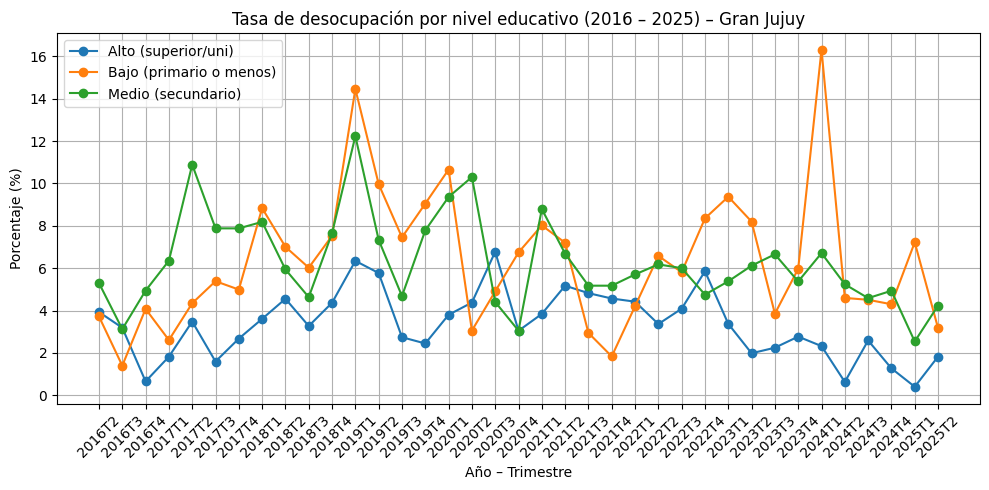

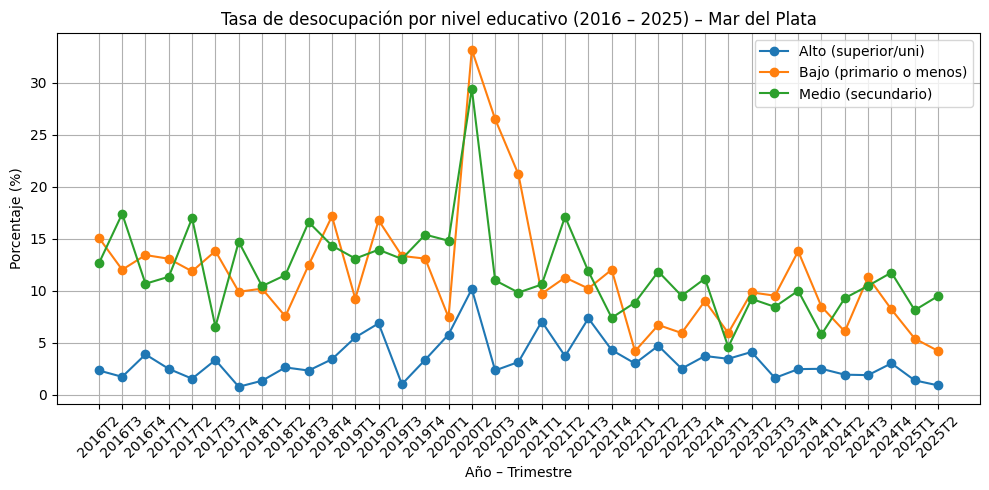

In [23]:
import matplotlib.pyplot as plt

def plot_desocup_educ(aglo=None, nombre="Ambos aglomerados"):
    df = tasas_educ.copy()

    if aglo is not None:
        df = df[df["AGLOMERADO"] == aglo]

    # Construimos etiqueta año–trimestre
    df["periodo"] = df["anio"].astype(str) + "T" + df["trimestre"].astype(str)

    plt.figure(figsize=(10, 5))
    for nivel in df["educacion"].unique():
        sub = df[df["educacion"] == nivel]
        plt.plot(sub["periodo"], sub["tasa_desocup"], marker="o", label=nivel)

    plt.xticks(rotation=45)
    plt.title(f"Tasa de desocupación por nivel educativo (2016 – 2025) – {nombre}")
    plt.xlabel("Año – Trimestre")
    plt.ylabel("Porcentaje (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejemplos de uso:
plot_desocup_educ(19, "Gran Jujuy")
plot_desocup_educ(34, "Mar del Plata")

In [24]:
#Tasas laborales por sexo
tasas_sexo = (
    eph[eph["sexo"].notna()]
    .groupby(["anio", "trimestre", "AGLOMERADO", "sexo"])
    .apply(lambda df: calcular_tasas_ponderadas(df, ponder_col))
    .reset_index()
)

tasas_sexo.head()

/tmp/ipython-input-3461280886.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: calcular_tasas_ponderadas(df, ponder_col))


,anio,trimestre,AGLOMERADO,sexo,ocupados,desocupados,inactivos,poblacion,pea,tasa_actividad,tasa_empleo,tasa_desocup
0,2016,2,19,Mujer,59153.0,2857.0,83080.0,172859.0,62010.0,35.873168,34.220376,4.607321
1,2016,2,19,Varón,75412.0,3467.0,52704.0,160109.0,78879.0,49.265813,47.100413,4.395340
2,2016,2,34,Mujer,105007.0,18614.0,168031.0,325766.0,123621.0,37.947791,32.233873,15.057312
3,2016,2,34,Varón,145712.0,14360.0,96614.0,296321.0,160072.0,54.019796,49.173700,8.970963
4,2016,3,19,Mujer,60466.0,1919.0,85454.0,175627.0,62385.0,35.521304,34.428647,3.076060


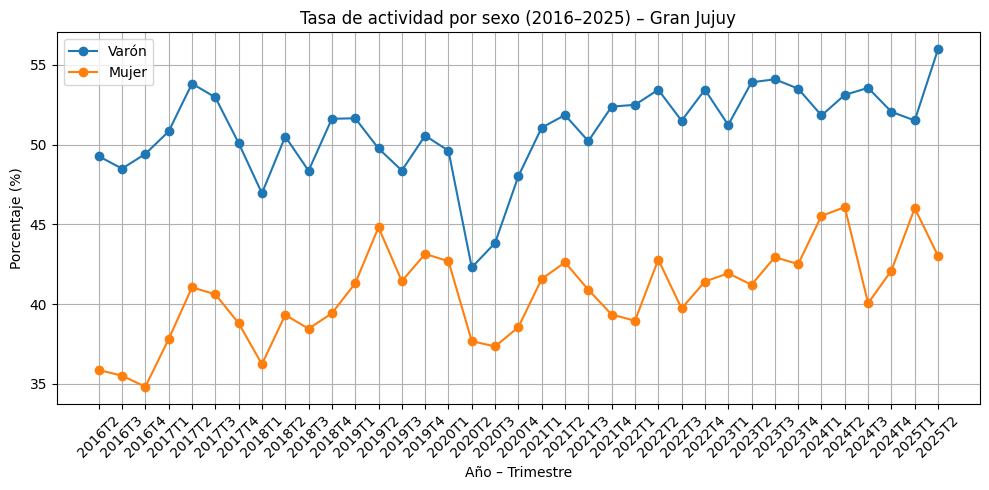

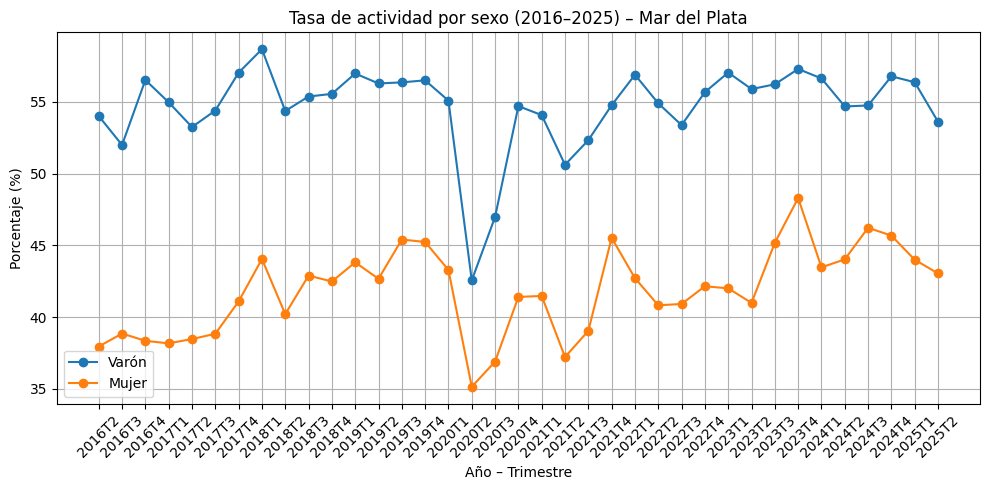

In [25]:
def plot_act_sexo(aglo=None, nombre="Ambos aglomerados"):
    df = tasas_sexo.copy()
    if aglo is not None:
        df = df[df["AGLOMERADO"] == aglo]

    df["periodo"] = df["anio"].astype(str) + "T" + df["trimestre"].astype(str)

    plt.figure(figsize=(10, 5))
    for s in ["Varón", "Mujer"]:
        sub = df[df["sexo"] == s]
        plt.plot(sub["periodo"], sub["tasa_actividad"], marker="o", label=s)

    plt.xticks(rotation=45)
    plt.title(f"Tasa de actividad por sexo (2016–2025) – {nombre}")
    plt.xlabel("Año – Trimestre")
    plt.ylabel("Porcentaje (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_act_sexo(19, "Gran Jujuy")
plot_act_sexo(34, "Mar del Plata")

In [26]:
#Ingreso nominal promedio por grupo de edad
ingreso_edad = (
    eph_ing[eph_ing["grupo_edad"].notna()]
    .groupby(["anio", "trimestre", "AGLOMERADO", "grupo_edad"])[["P47T", ponder_col]]
    .apply(lambda df: (df["P47T"] * df[ponder_col]).sum() / df[ponder_col].sum())
    .reset_index(name="ingreso_nominal_prom")
)

ingreso_edad.head()

/tmp/ipython-input-4200197751.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["anio", "trimestre", "AGLOMERADO", "grupo_edad"])[["P47T", ponder_col]]


,anio,trimestre,AGLOMERADO,grupo_edad,ingreso_nominal_prom
0,2016,2,19,15-29,4336.516188
1,2016,2,19,30-44,7722.883075
2,2016,2,19,45-64,8398.949509
3,2016,2,19,65 y más,7611.751903
4,2016,2,34,15-29,5809.897248


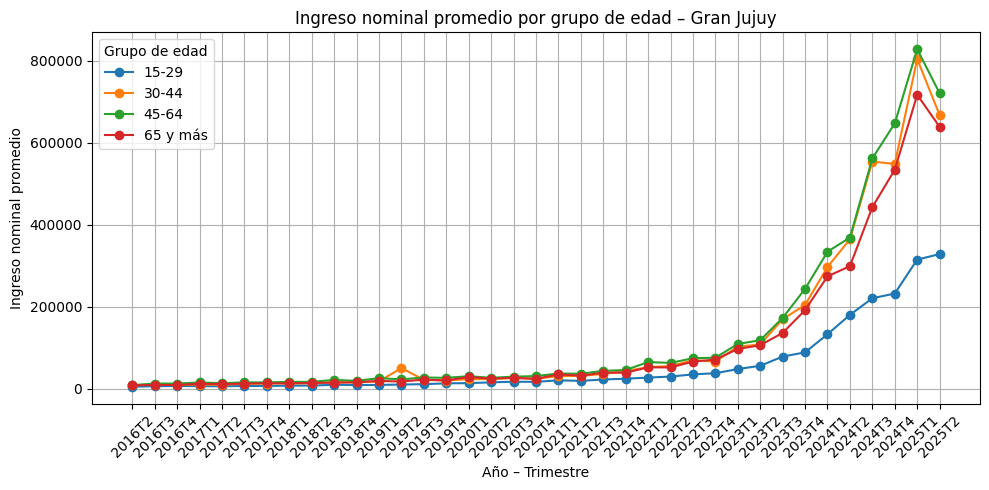

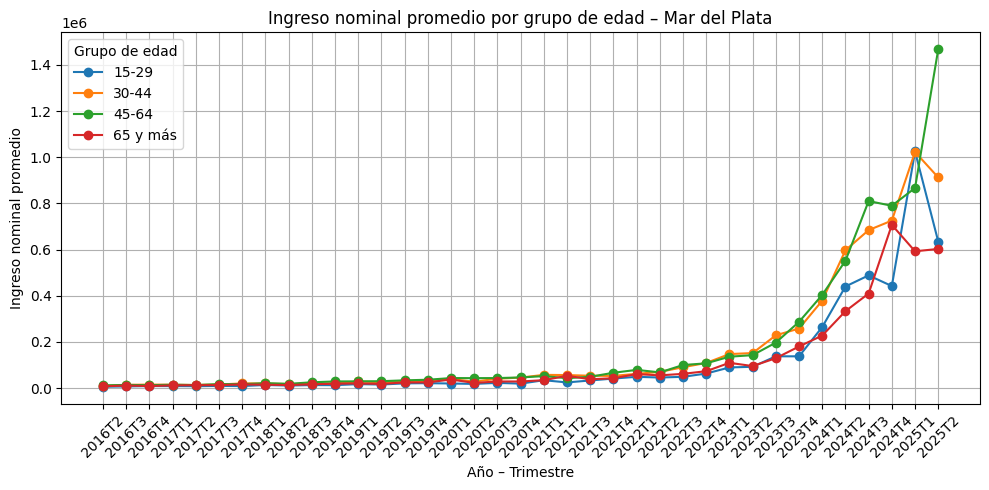

In [27]:
def plot_ingreso_edad(aglo, nombre):
    df = ingreso_edad[ingreso_edad["AGLOMERADO"] == aglo].copy()
    df["periodo"] = df["anio"].astype(str) + "T" + df["trimestre"].astype(str)

    plt.figure(figsize=(10, 5))
    for grupo in df["grupo_edad"].unique():
        tramo = df[df["grupo_edad"] == grupo]
        plt.plot(tramo["periodo"], tramo["ingreso_nominal_prom"], marker="o", label=str(grupo))

    plt.xticks(rotation=45)
    plt.title(f"Ingreso nominal promedio por grupo de edad – {nombre}")
    plt.xlabel("Año – Trimestre")
    plt.ylabel("Ingreso nominal promedio")
    plt.legend(title="Grupo de edad")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ingreso_edad(19, "Gran Jujuy")
plot_ingreso_edad(34, "Mar del Plata")

In [28]:
def plot_tasas_educ(tasas_df, aglo, nombre_aglo):
    df = tasas_df[tasas_df["AGLOMERADO"] == aglo].copy()
    df["periodo"] = df["anio"].astype(str) + "T" + df["trimestre"].astype(str)

    niveles = df["educacion"].unique()

    # --- Actividad ---
    plt.figure(figsize=(12,6))
    for niv in niveles:
        sub = df[df["educacion"] == niv]
        plt.plot(sub["periodo"], sub["tasa_actividad"], marker="o", label=niv)

    plt.xticks(rotation=45)
    plt.title(f"Tasa de actividad por nivel educativo – {nombre_aglo} (2016–2025)")
    plt.xlabel("Año – Trimestre")
    plt.ylabel("Porcentaje (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Empleo ---
    plt.figure(figsize=(12,6))
    for niv in niveles:
        sub = df[df["educacion"] == niv]
        plt.plot(sub["periodo"], sub["tasa_empleo"], marker="o", label=niv)

    plt.xticks(rotation=45)
    plt.title(f"Tasa de empleo por nivel educativo – {nombre_aglo} (2016–2025)")
    plt.xlabel("Año – Trimestre")
    plt.ylabel("Porcentaje (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Desocupación ---
    plt.figure(figsize=(12,6))
    for niv in niveles:
        sub = df[df["educacion"] == niv]
        plt.plot(sub["periodo"], sub["tasa_desocup"], marker="o", label=niv)

    plt.xticks(rotation=45)
    plt.title(f"Tasa de desocupación por nivel educativo – {nombre_aglo} (2016–2025)")
    plt.xlabel("Año – Trimestre")
    plt.ylabel("Porcentaje (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


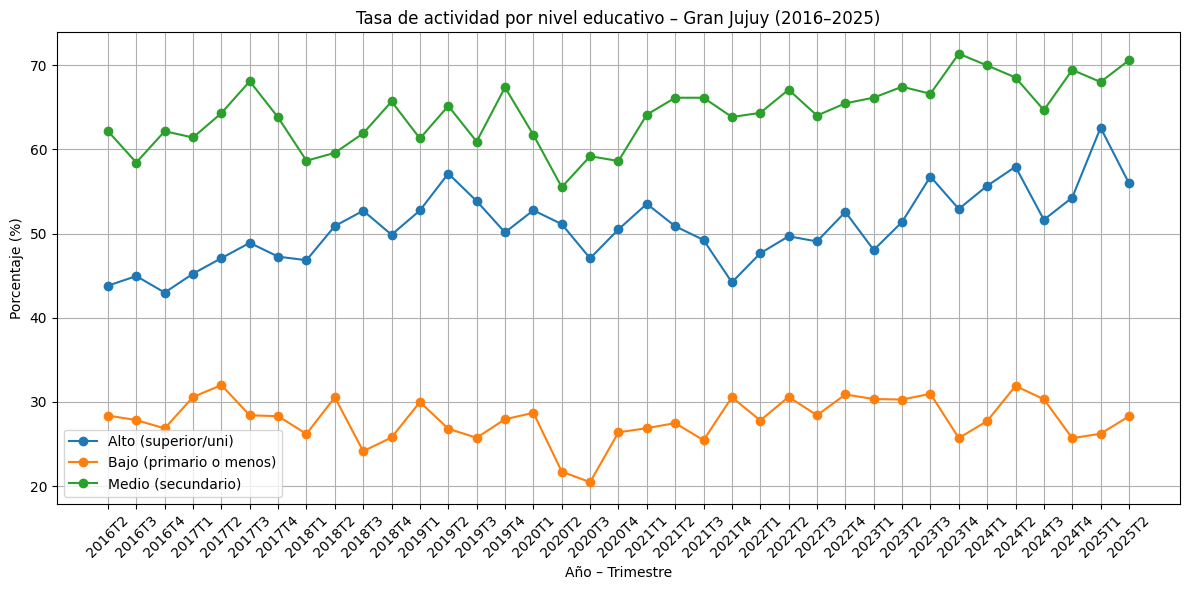

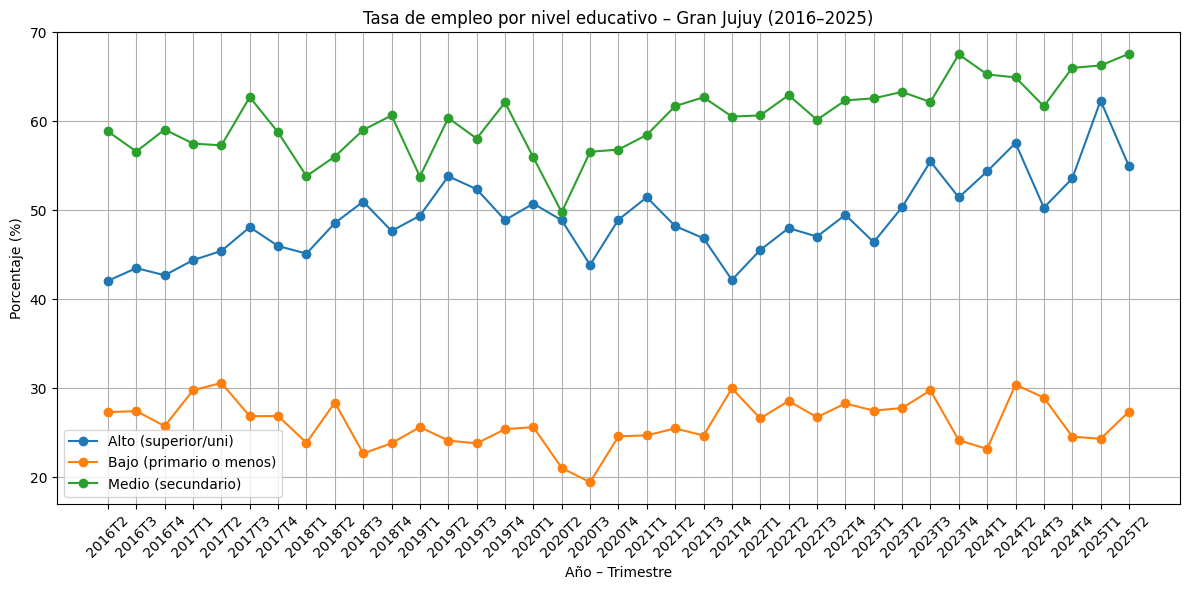

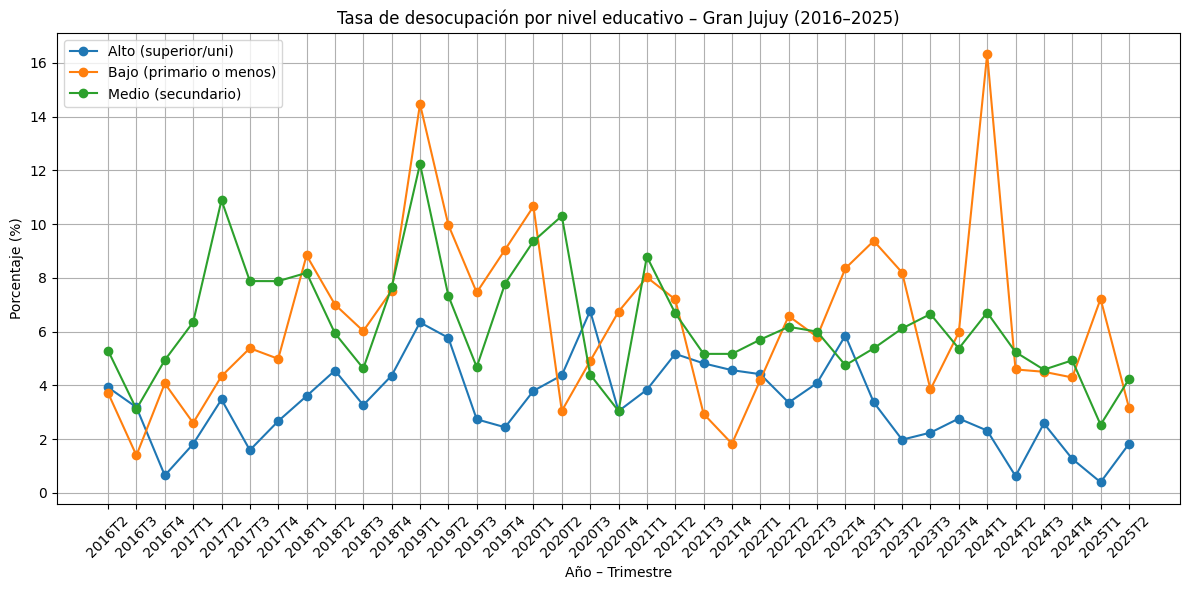

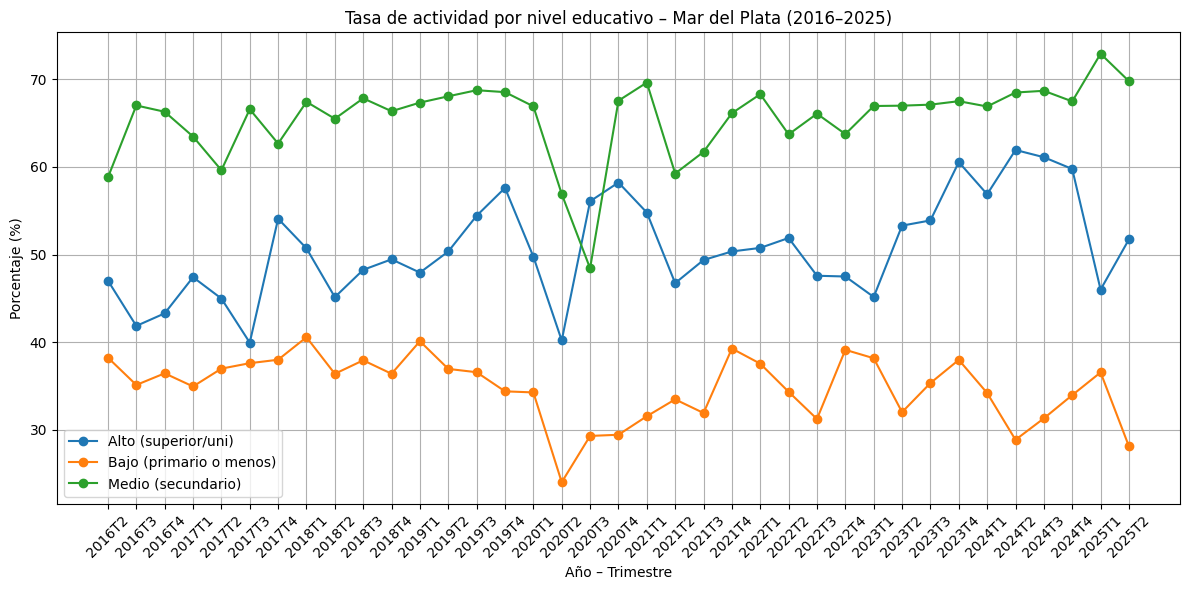

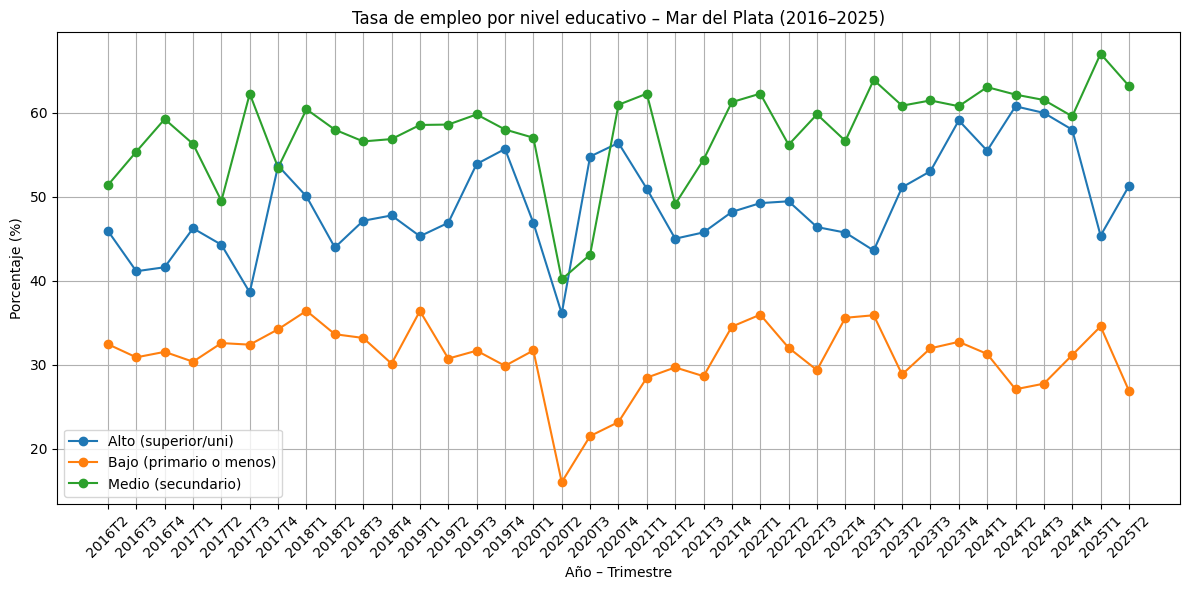

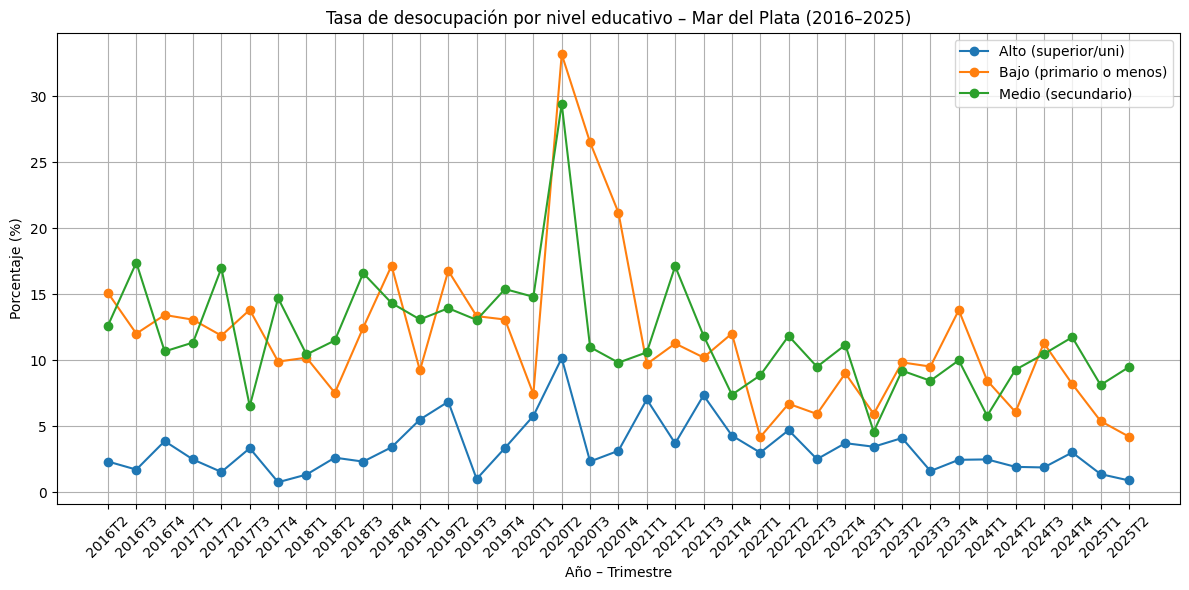

In [29]:
plot_tasas_educ(tasas_educ, 19, "Gran Jujuy")
plot_tasas_educ(tasas_educ, 34, "Mar del Plata")


In [30]:
# Modelo de regresión lineal para imputar ingresos no declarados
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Base para el modelo

df_model = eph.copy()

# Garantizar que el ingreso sea numérico
df_model["ingreso"] = pd.to_numeric(df_model["P47T"], errors="coerce")

# Casos con ingreso declarado (>0)
mask_train = df_model["ingreso"] > 0

# Casos a imputar: ingreso 0 o faltante
mask_missing = df_model["ingreso"].isna() | (df_model["ingreso"] == 0)

df_train   = df_model[mask_train].copy()
df_missing = df_model[mask_missing].copy()

# print("Observaciones con ingreso declarado:", len(df_train))
# print("Observaciones a imputar:", len(df_missing))

# Variables explicativas (usá las que ya creaste en el multivariado)
features = ["AGLOMERADO", "sexo", "grupo_edad", "educacion"]

X_train = pd.get_dummies(df_train[features], drop_first=True)
y_train = df_train["ingreso"]

X_missing = pd.get_dummies(df_missing[features], drop_first=True)

# Alinear columnas entre train y missing
X_missing = X_missing.reindex(columns=X_train.columns, fill_value=0)

# Ajustar regresión

modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predicciones sobre el propio train para evaluar
pred_train = modelo.predict(X_train)

mae  = mean_absolute_error(y_train, pred_train)
rmse = np.sqrt(mean_squared_error(y_train, pred_train))

# print("\n--- Rendimiento del modelo ---")
# print("MAE :", round(mae, 2))
# print("RMSE:", round(rmse, 2))

coef = pd.Series(modelo.coef_, index=X_train.columns)
coef_ord = coef.reindex(coef.abs().sort_values(ascending=False).index)

# print("\n--- Principales variables explicativas (coeficientes) ---")
display(coef_ord.head(10))

,0
educacion_Bajo (primario o menos),-96691.780649
educacion_Medio (secundario),-60692.641747
grupo_edad_45-64,55093.113513
grupo_edad_65 y más,40647.056187
sexo_Varón,37282.908770
grupo_edad_30-44,36962.836931
AGLOMERADO,710.562176


In [31]:
#Imputar ingresos

df_missing["ingreso_imputado"] = modelo.predict(X_missing)

# Para tener una sola variable ingreso final:
df_missing["ingreso_final"] = df_missing["ingreso_imputado"]
df_train["ingreso_final"]   = df_train["ingreso"]  # el declarado

# Unificar base con ingreso imputado
df_imputado = pd.concat([df_train, df_missing], ignore_index=True)

print("Filas en la base final imputada:", len(df_imputado))

Filas en la base final imputada: 93080


In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("default")
plt.rcParams.update({
    "figure.figsize": (8,6),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 120
})

In [38]:
# Predicciones en el set de entrenamiento
y_train_pred = modelo.predict(X_train)
residuales   = y_train - y_train_pred

# Para los gráficos, nos quedamos solo con valores positivos de ingreso
# (los ingresos declarados ya son >0, pero por las dudas filtramos)
mask_pos = (y_train > 0) & (y_train_pred > 0)

y_obs_pos  = y_train[mask_pos]
y_pred_pos = y_train_pred[mask_pos]
resid_pos  = residuales[mask_pos]

# Versión en log10 para los ingresos (mejora muchísimo la escala)
import numpy as np

log_y_obs  = np.log10(y_obs_pos)
log_y_pred = np.log10(y_pred_pos)


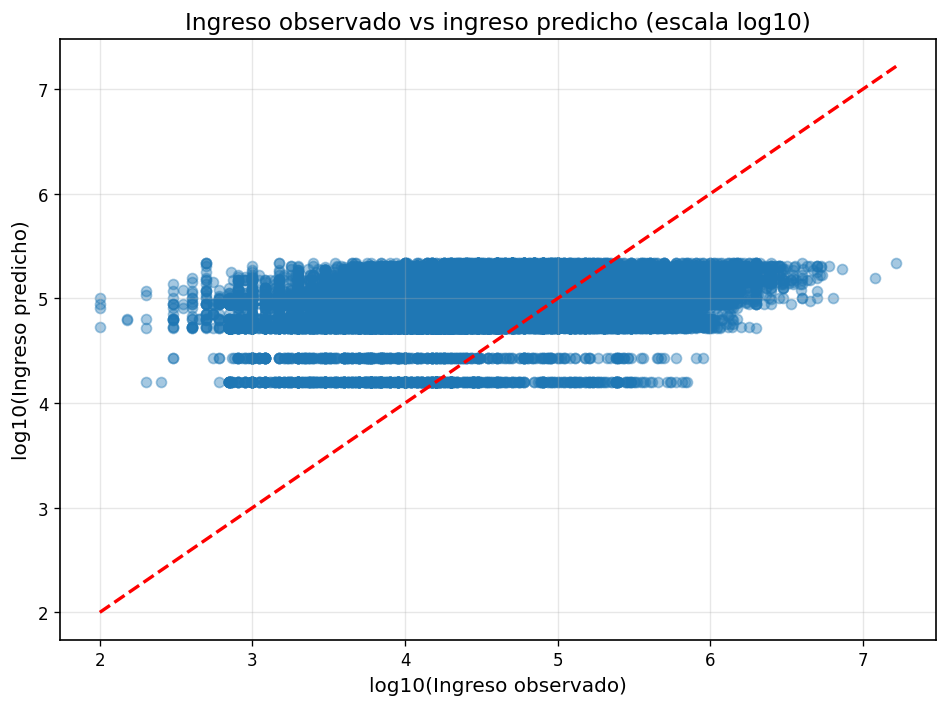

In [39]:
plt.figure()

plt.scatter(log_y_obs, log_y_pred, alpha=0.4)

# Línea 45° (perfecto ajuste) también en escala log
min_val = min(log_y_obs.min(), log_y_pred.min())
max_val = max(log_y_obs.max(), log_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)

plt.title("Ingreso observado vs ingreso predicho (escala log10)")
plt.xlabel("log10(Ingreso observado)")
plt.ylabel("log10(Ingreso predicho)")
plt.tight_layout()
plt.show()

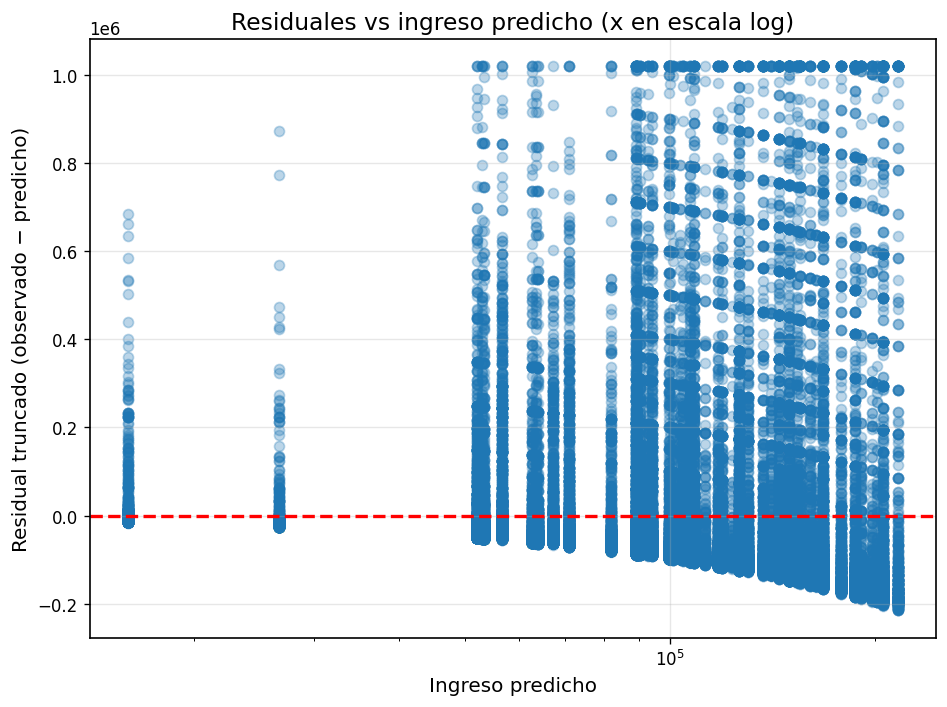

In [40]:
plt.figure()

# Recortamos el 1% más extremo para que el gráfico sea legible
q99 = np.percentile(np.abs(resid_pos), 99)
resid_trunc = np.clip(resid_pos, -q99, q99)

plt.scatter(y_pred_pos, resid_trunc, alpha=0.3)

# Escala logarítmica en el eje X (ingreso predicho)
plt.xscale("log")

plt.axhline(0, color="red", linestyle="--", linewidth=2)

plt.title("Residuales vs ingreso predicho (x en escala log)")
plt.xlabel("Ingreso predicho")
plt.ylabel("Residual truncado (observado − predicho)")
plt.tight_layout()
plt.show()


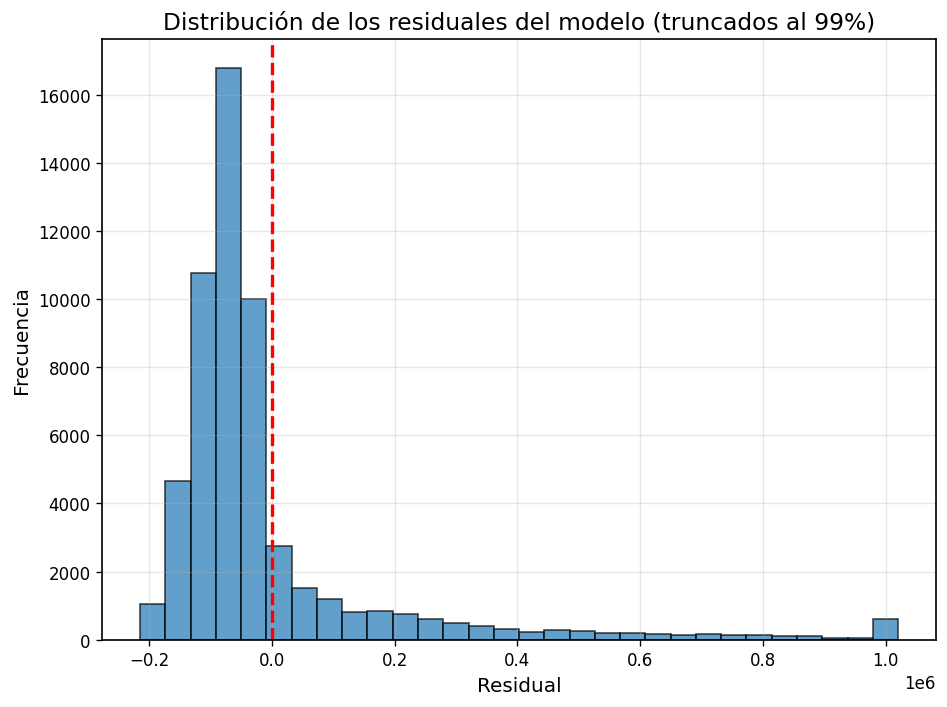

In [41]:
plt.figure()

plt.hist(resid_trunc, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", linewidth=2)

plt.title("Distribución de los residuales del modelo (truncados al 99%)")
plt.xlabel("Residual")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()



In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# ===============================
# Cargar shapefile / geojson
# ===============================
agl = gpd.read_file("/content/drive/MyDrive/TP_Analisis_de_datos/aglomerados_eph.json")

# Filtrar aglomerados que quieres mapear
# >>>>> TASA DE ACTIVIDAD <<<<<
targets = {
    "Jujuy - Palpalá": 45.2,
    "Mar del Plata - Batán": 52.1
}

# >>>>> ESCALA COMÚN PARA AMBOS MAPAS <<<<<
vmin = min(targets.values()) - 2
vmax = max(targets.values()) + 2

agl_merc = agl.to_crs(3857)

# ===============================
# Función para crear mapa
# ===============================
def plot_aglomerado(nombre, tasa):
    geo = agl_merc[agl_merc["eph_aglome"].str.contains(nombre, case=False)]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Color según la escala común
    color_norm = (tasa - vmin) / (vmax - vmin)
    color = plt.cm.Reds(color_norm)

    geo.plot(
        column=None,
        edgecolor="black",
        color=color,
        linewidth=1.2,
        ax=ax
    )

    # Agregar mapa base
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=agl_merc.crs)

    # Título
    ax.set_title(f"Tasa de Actividad – {nombre}", fontsize=18)

    # Cuadro de datos
    ax.text(
        0.02, 0.98,
        f"{nombre}\nTasa de actividad: {tasa}%",
        transform=ax.transAxes,
        fontsize=12,
        ha="left", va="top",
        bbox=dict(facecolor="white", alpha=0.8)
    )

    # Barra de color unificada
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Tasa de actividad (%)")

    # Quitar ejes
    ax.axis("off")

    plt.show()

# ===============================
# Generar ambos mapas
# ===============================
plot_aglomerado("Jujuy - Palpalá", targets["Jujuy - Palpalá"])
plot_aglomerado("Mar del Plata - Batán", targets["Mar del Plata - Batán"])


ModuleNotFoundError: No module named 'contextily'

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# ===============================
# Cargar shapefile / geojson
# ===============================
agl = gpd.read_file("/content/drive/MyDrive/TP_Analisis_de_datos/aglomerados_eph.json")

# Filtrar aglomerados que quieres mapear
targets = {
    "Jujuy - Palpalá": 12.1,
    "Mar del Plata - Batán": 9.4
}

# >>>>> ESCALA COMÚN PARA AMBOS MAPAS <<<<<
vmin = min(targets.values()) - 2
vmax = max(targets.values()) + 2

# Asegurar que esté en el sistema web mercator para usar OSM
agl_merc = agl.to_crs(3857)

# ===============================
# Función para crear mapa
# ===============================
def plot_aglomerado(nombre, tasa):
    # Buscar geometría según el nombre correcto en tu archivo
    geo = agl_merc[agl_merc["eph_aglome"].str.contains(nombre, case=False)]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Color según la escala común
    color_norm = (tasa - vmin) / (vmax - vmin)

    geo.plot(
        column=None,
        edgecolor="black",
        color=plt.cm.Reds(color_norm),
        linewidth=1.2,
        ax=ax
    )

    # Agregar mapa base
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=agl_merc.crs)

    # Título
    ax.set_title(f"Tasa de Desocupación – {nombre}", fontsize=18)

    # Cuadro de datos
    ax.text(
        0.02, 0.98,
        f"{nombre}\nTasa de desocupación: {tasa}%",
        transform=ax.transAxes,
        fontsize=12,
        ha="left", va="top",
        bbox=dict(facecolor="white", alpha=0.8)
    )

    # Barra de color con la MISMA escala para todos
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Tasa de desocupación (%)")

    # Quitar ejes
    ax.axis("off")

    plt.show()

# ===============================
# Generar ambos mapas
# ===============================
plot_aglomerado("Jujuy - Palpalá", 12.1)
plot_aglomerado("Mar del Plata - Batán", 9.4)


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Cargar geojson
agl = gpd.read_file("/content/drive/MyDrive/TP_Analisis_de_datos/aglomerados_eph.json")

# Tasas de ACTIVIDAD que calculaste (cambiá los números si son otros)
targets = {
    "Jujuy - Palpalá": 45.2,
    "Mar del Plata - Batán": 52.1
}

# Escala común para los colores
vmin = min(targets.values()) - 3
vmax = max(targets.values()) + 3

# Pasar a Mercator por si después querés usar contextily
agl_merc = agl.to_crs(3857)

# Armar GeoDataFrame con tasas de actividad
df_tasas = pd.DataFrame({
    "eph_aglome": list(targets.keys()),
    "tasa_actividad": list(targets.values())
})

agl_sel = agl_merc[agl_merc["eph_aglome"].isin(df_tasas["eph_aglome"])]
gdf_act = agl_sel.merge(df_tasas, on="eph_aglome")


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, nombre in zip(axes, targets.keys()):
    sub = gdf_act[gdf_act["eph_aglome"] == nombre]

    # dibuja el polígono
    sub.plot(
        column="tasa_actividad",
        cmap="Reds",
        vmin=vmin,
        vmax=vmax,
        edgecolor="black",
        linewidth=1.2,
        ax=ax,
        legend=False
    )

    # zoom para que el aglomerado “entre bien” en cada subplot
    xmin, ymin, xmax, ymax = sub.total_bounds
    dx = (xmax - xmin) * 0.1
    dy = (ymax - ymin) * 0.1
    ax.set_xlim(xmin - dx, xmax + dx)
    ax.set_ylim(ymin - dy, ymax + dy)
    ax.set_aspect("equal")

    ax.set_title(f"Tasa de Actividad – {nombre}", fontsize=12)
    ax.set_axis_off()

    tasa = sub["tasa_actividad"].iloc[0]
    ax.text(
        0.02, 0.98,
        f"{nombre}\nTasa de actividad: {tasa:.1f}%",
        transform=ax.transAxes,
        fontsize=10,
        ha="left", va="top",
        bbox=dict(facecolor="white", alpha=0.85)
    )

# Barra de color compartida (abajo de los dos mapas)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(norm=norm, cmap="Reds")
sm._A = []
cbar = fig.colorbar(
    sm,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    fraction=0.05,
    pad=0.08
)
cbar.set_label("Tasa de actividad (%)", fontsize=11)

fig.suptitle("Comparación de tasa de actividad – Jujuy vs Mar del Plata", fontsize=14)

# dejar espacio para título y barra de color
plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.show()
